In [1]:
"""
Controlling building heating system via Differentiable predictive control (DPC)

system: single-zone building model
        fully observable white-box model setup
"""

import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase, pltOL

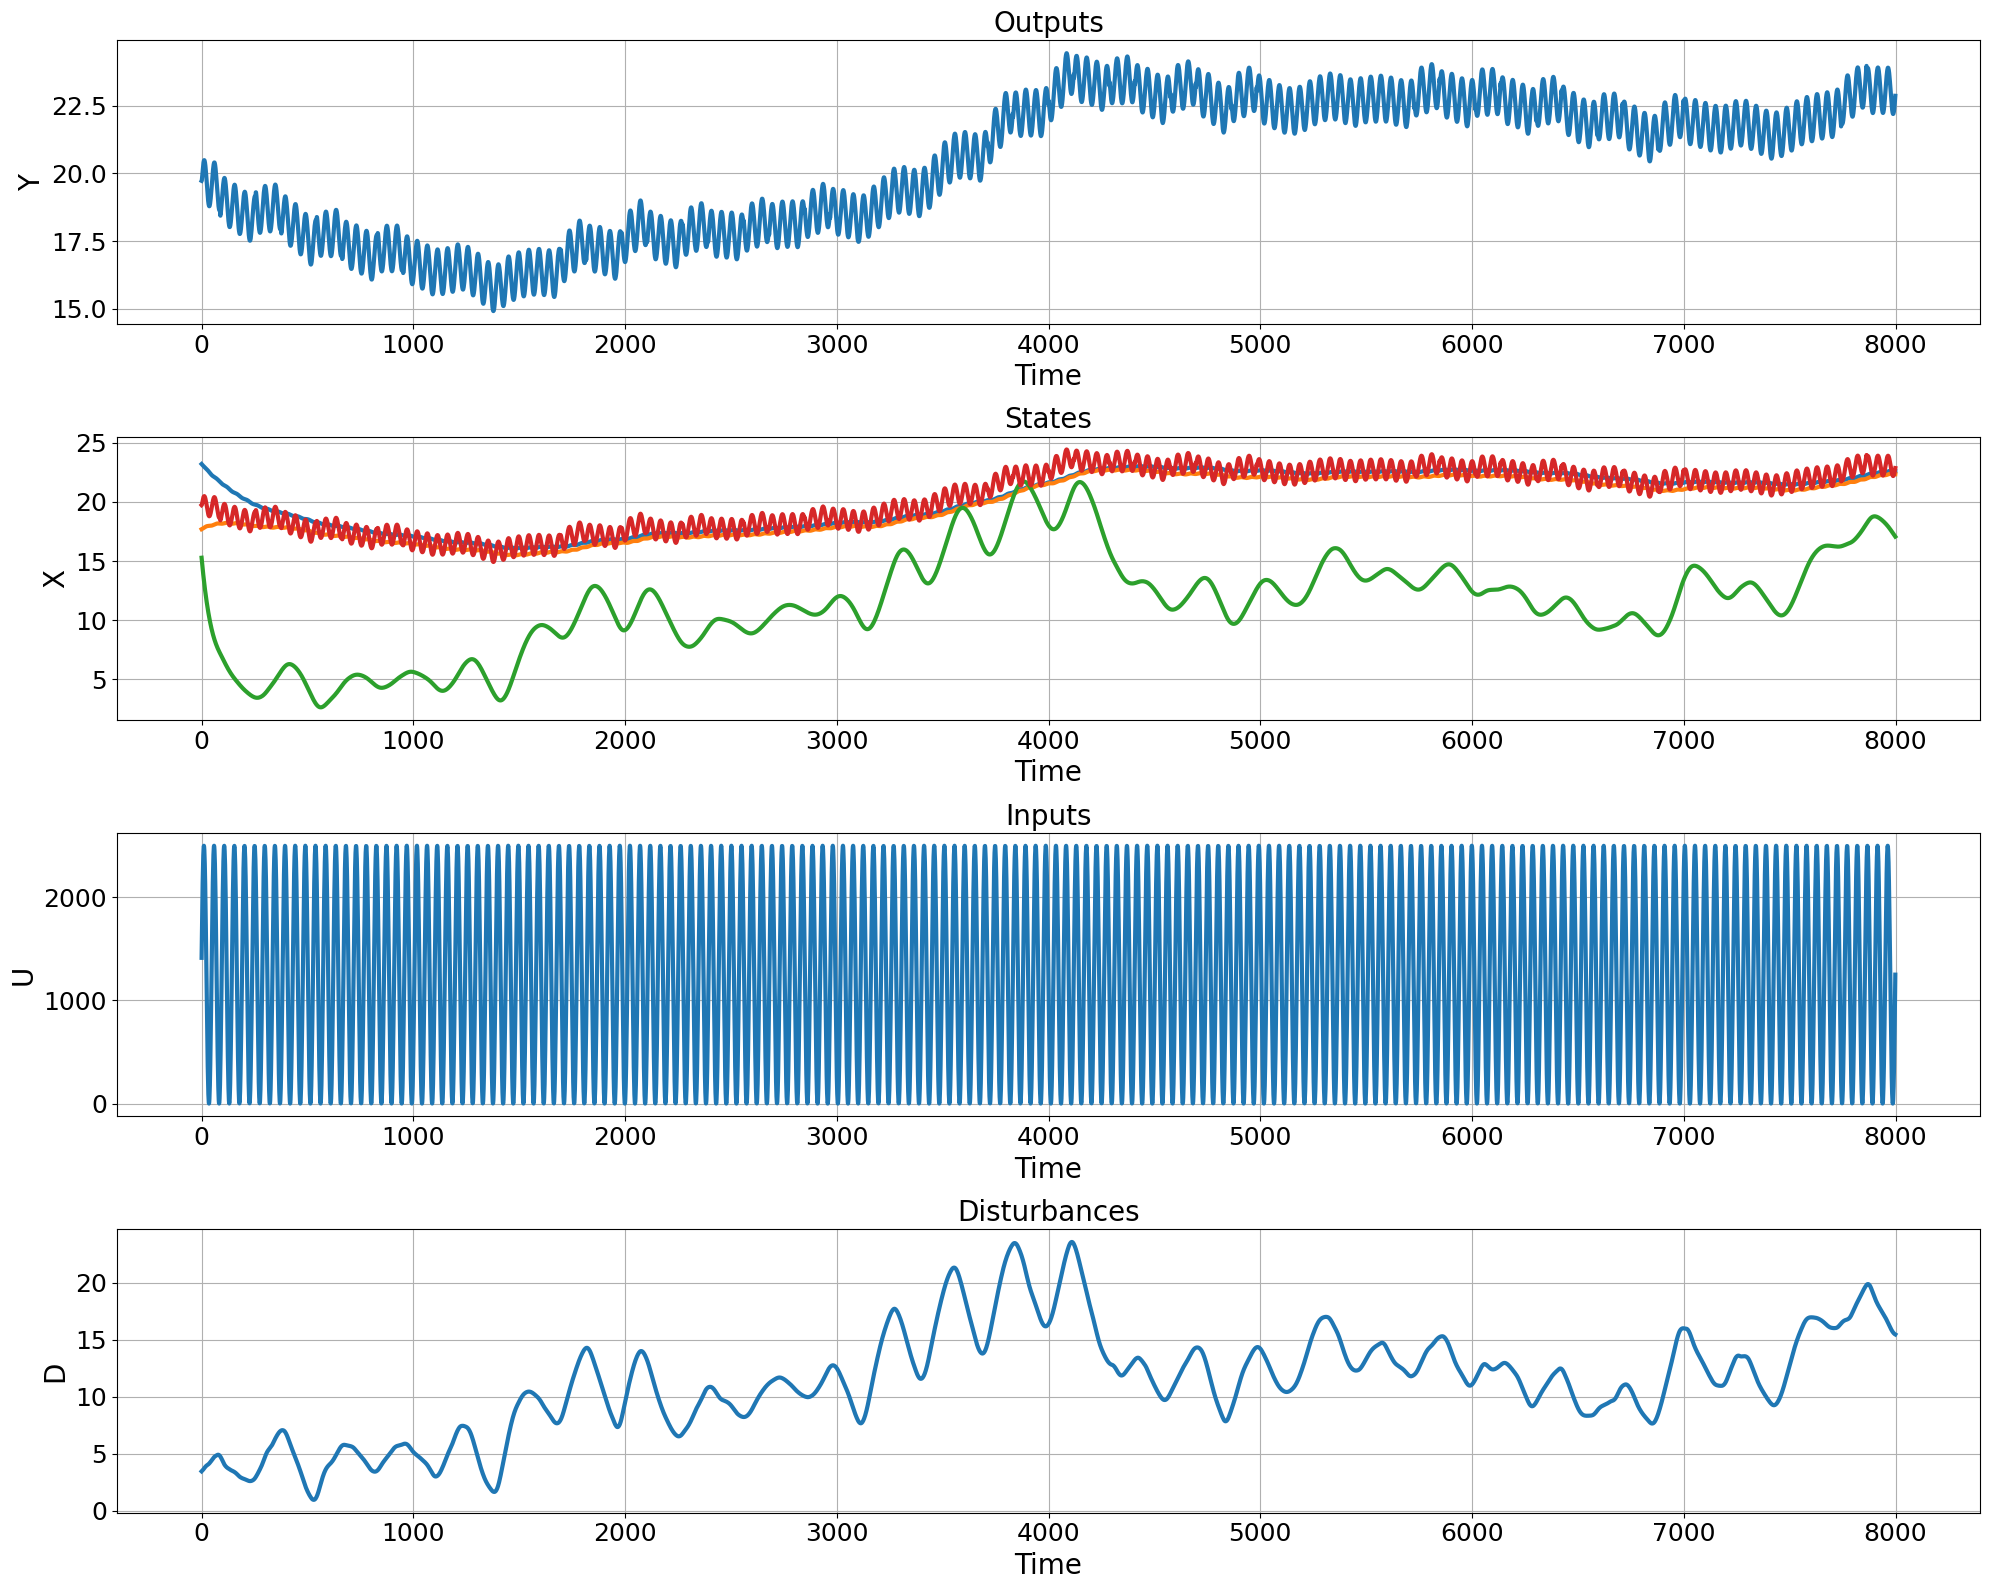

In [3]:

"""
# # #  Ground truth system model
"""
system = psl.systems['LinearSimpleSingleZone']()

# simulate the building model over 1000 timesteps
nsim = 8000
sim = system.simulate(nsim=nsim, x0=system.get_x0(), U=system.get_U(nsim + 1))
# plot open-loop response
pltOL(Y=sim['Y'], X=sim['X'], U=sim['U'], D=sim['D'])

# extract exact state space model matrices:
A = torch.tensor(system.params[2]['A'])
B = torch.tensor(system.params[2]['Beta'])
C = torch.tensor(system.params[2]['C'])
E = torch.tensor(system.params[2]['E'])

# get control action bounds
umin = torch.tensor(system.umin)
umax = torch.tensor(system.umax)

# problem dimensions
nx = system.nx    # number of states
nu = system.nu    # number of control inputs
nd = E.shape[1]           # number of disturbances
nd_obsv = system.nd    # number of observable disturbances
ny = system.ny           # number of controlled outputs
nref = system.ny           # number of references
y_idx = 3

In [4]:
x0 = torch.tensor(system.get_x0(), dtype=torch.float32)

In [5]:
x0

tensor([22.2431, 18.4910,  7.3559, 23.1931])

In [6]:
system.get_x0() @ C.numpy().T

array([19.629572], dtype=float32)

In [7]:

"""
# # #  Dataset
"""
nsteps = 100  # prediction horizon
n_samples = 1000    # number of sampled scenarios

# range for lower comfort bound
x_min = 18.
x_max = 22.
#  sampled references for training the policy
list_xmin = [x_min+(x_max-x_min)*torch.rand(1, 1)*torch.ones(nsteps, nref)
              for k in range(n_samples)]
xmin = torch.cat(list_xmin)
batched_ymin = xmin.reshape([n_samples, nsteps, nref])
batched_ymax = batched_ymin+2.0
# get sampled disturbance trajectories from the simulation model
list_dist = [torch.tensor(system.get_D(nsteps))
              for k in range(n_samples)]
batched_dist = torch.stack(list_dist, dim=0)
# get sampled initial conditions
list_x0 = [torch.tensor(system.get_x0().reshape(1, nx))
              for k in range(n_samples)]
batched_x0 = torch.stack(list_x0, dim=0)
# Training dataset
train_data = DictDataset({'x': batched_x0,
                          'ymin': batched_ymin,
                          'ymax': batched_ymax,
                          'd': batched_dist},
                          name='train')

# references for dev set
list_xmin = [x_min+(x_max-x_min)*torch.rand(1, 1)*torch.ones(nsteps, nref)
              for k in range(n_samples)]
xmin = torch.cat(list_xmin)
batched_ymin = xmin.reshape([n_samples, nsteps, nref])
batched_ymax = batched_ymin+2.0
# get sampled disturbance trajectories from the simulation model
list_dist = [torch.tensor(system.get_D(nsteps))
              for k in range(n_samples)]
batched_dist = torch.stack(list_dist, dim=0)
# get sampled initial conditions
list_x0 = [torch.tensor(system.get_x0().reshape(1, nx))
              for k in range(n_samples)]
batched_x0 = torch.stack(list_x0, dim=0)
# Development dataset
dev_data = DictDataset({'x': batched_x0,
                        'ymin': batched_ymin,
                        'ymax': batched_ymax,
                        'd': batched_dist},
                        name='dev')

# torch dataloaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            collate_fn=train_data.collate_fn,
                                            shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                          collate_fn=dev_data.collate_fn,
                                          shuffle=False)

# normalization statistics
x_mean = batched_x0.mean(dim=[0, 1])
x_std = batched_x0.std(dim=[0, 1])
ymin_mean = batched_ymin.mean(dim=[0, 1])
ymin_std = batched_ymin.std(dim=[0, 1])
ymax_mean = batched_ymax.mean(dim=[0, 1])
ymax_std = batched_ymax.std(dim=[0, 1])
d_mean = batched_dist.mean(dim=[0, 1])
d_std = batched_dist.std(dim=[0, 1])
# concatenate means and variances
means = torch.cat([x_mean, ymin_mean, ymax_mean, d_mean])
stds = torch.cat([x_std, ymin_std, ymax_std, d_std])

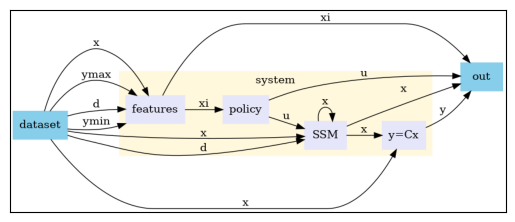

In [8]:

"""
# # #  System model and Control policy in Neuromancer
"""
# state-space model of the building dynamics:
#   x_k+1 =  A x_k + B u_k + E d_k
xnext = lambda x, u, d: x @ A.T + u @ B.T + d @ E.T
state_model = Node(xnext, ['x', 'u', 'd'], ['x'], name='SSM')
#   y_k = C x_k
ynext = lambda x: x @ C.T
output_model = Node(ynext, ['x'], ['y'], name='y=Cx')

# get normalization layer to generate policy features
def normalize_features(*inputs):
    x = torch.cat(inputs, dim=-1)
    return (x - means) / stds
# features node
features = Node(normalize_features, ['x', 'ymin', 'ymax', 'd'],
              ['xi'], name='features')

# neural net control policy
net = blocks.MLP_bounds(insize=nx + 2*nref + nd,
                        outsize=nu, hsizes=[32, 32],
                        nonlin=activations['gelu'],
                        min=umin, max=umax)
# symbolic policy
policy = Node(net, ['xi'], ['u'], name='policy')

# closed-loop system model
cl_system = System([features, policy, state_model, output_model],
                    nsteps=nsteps,
                    name='cl_system')
cl_system.show()

In [9]:

"""
# # #  Differentiable Predictive Control objectives and constraints
"""
# variables
y = variable('y')
u = variable('u')
ymin = variable('ymin')
ymax = variable('ymax')

# objectives
action_loss = 0.01 * (u == 0.0)  # energy minimization
du_loss = 0.1 * (u[:,:-1,:] - u[:,1:,:] == 0.0)  # delta u minimization
# # constraints
state_lower_bound_penalty = 50.*(y > ymin)
state_upper_bound_penalty = 50.*(y < ymax)
# # objectives and constraints names for nicer plot
action_loss.name = 'action_loss'
du_loss.name = 'du_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
# list of constraints and objectives
objectives = [action_loss, du_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty
]

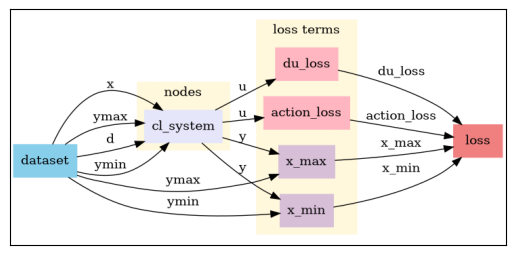

In [10]:

"""
# # #  Differentiable optimal control problem
"""
# data -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
nodes = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss)
# plot computational graph
problem.show()

In [11]:

"""
# # #  Solving the problem
"""
epochs = 200
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=epochs,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100, 100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100, 99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 61.686134338378906
epoch: 1  train_loss: 57.35167694091797
epoch: 2  train_loss: 52.934181213378906
epoch: 3  train_loss: 47.88965606689453
epoch: 4  train_loss: 42.0897331237793
epoch: 5  train_loss: 36.00733947753906
epoch: 6  train_loss: 30.566585540771484
epoch: 7  train_loss: 26.46085548400879
epoch: 8  train_loss: 23.599925994873047
epoch: 9  train_loss: 21.673587799072266
epoch: 10  train_loss: 20.372255325317383
epoch: 11  train_loss: 19.495025634765625
epoch: 12  train_loss: 18.880931854248047
epoch: 13  train_loss: 18.417940139770508
epoch: 14  train_loss: 18.065982818603516
epoch: 15  train_loss: 17.795047760009766
epoch: 16  train_loss: 17.584762573242188
epoch: 17  train_loss: 17.414546966552734
epoch: 18  train_loss: 17.267215728759766
epoch: 19  train_loss: 17.132966995239258
epoch: 20  train_loss: 17.008405685424805
epoch: 21  train_loss: 16.892181396484375
epoch: 22  train_loss: 16.78190040588379
epoch: 23  train_loss: 16.675540924072266
epoch: 24

<All keys matched successfully>


Test Closed Loop System 



(<Figure size 2000x1600 with 4 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='x'>],
        [<Axes: xlabel='Time', ylabel='u'>],
        [<Axes: xlabel='Time', ylabel='d'>]], dtype=object))

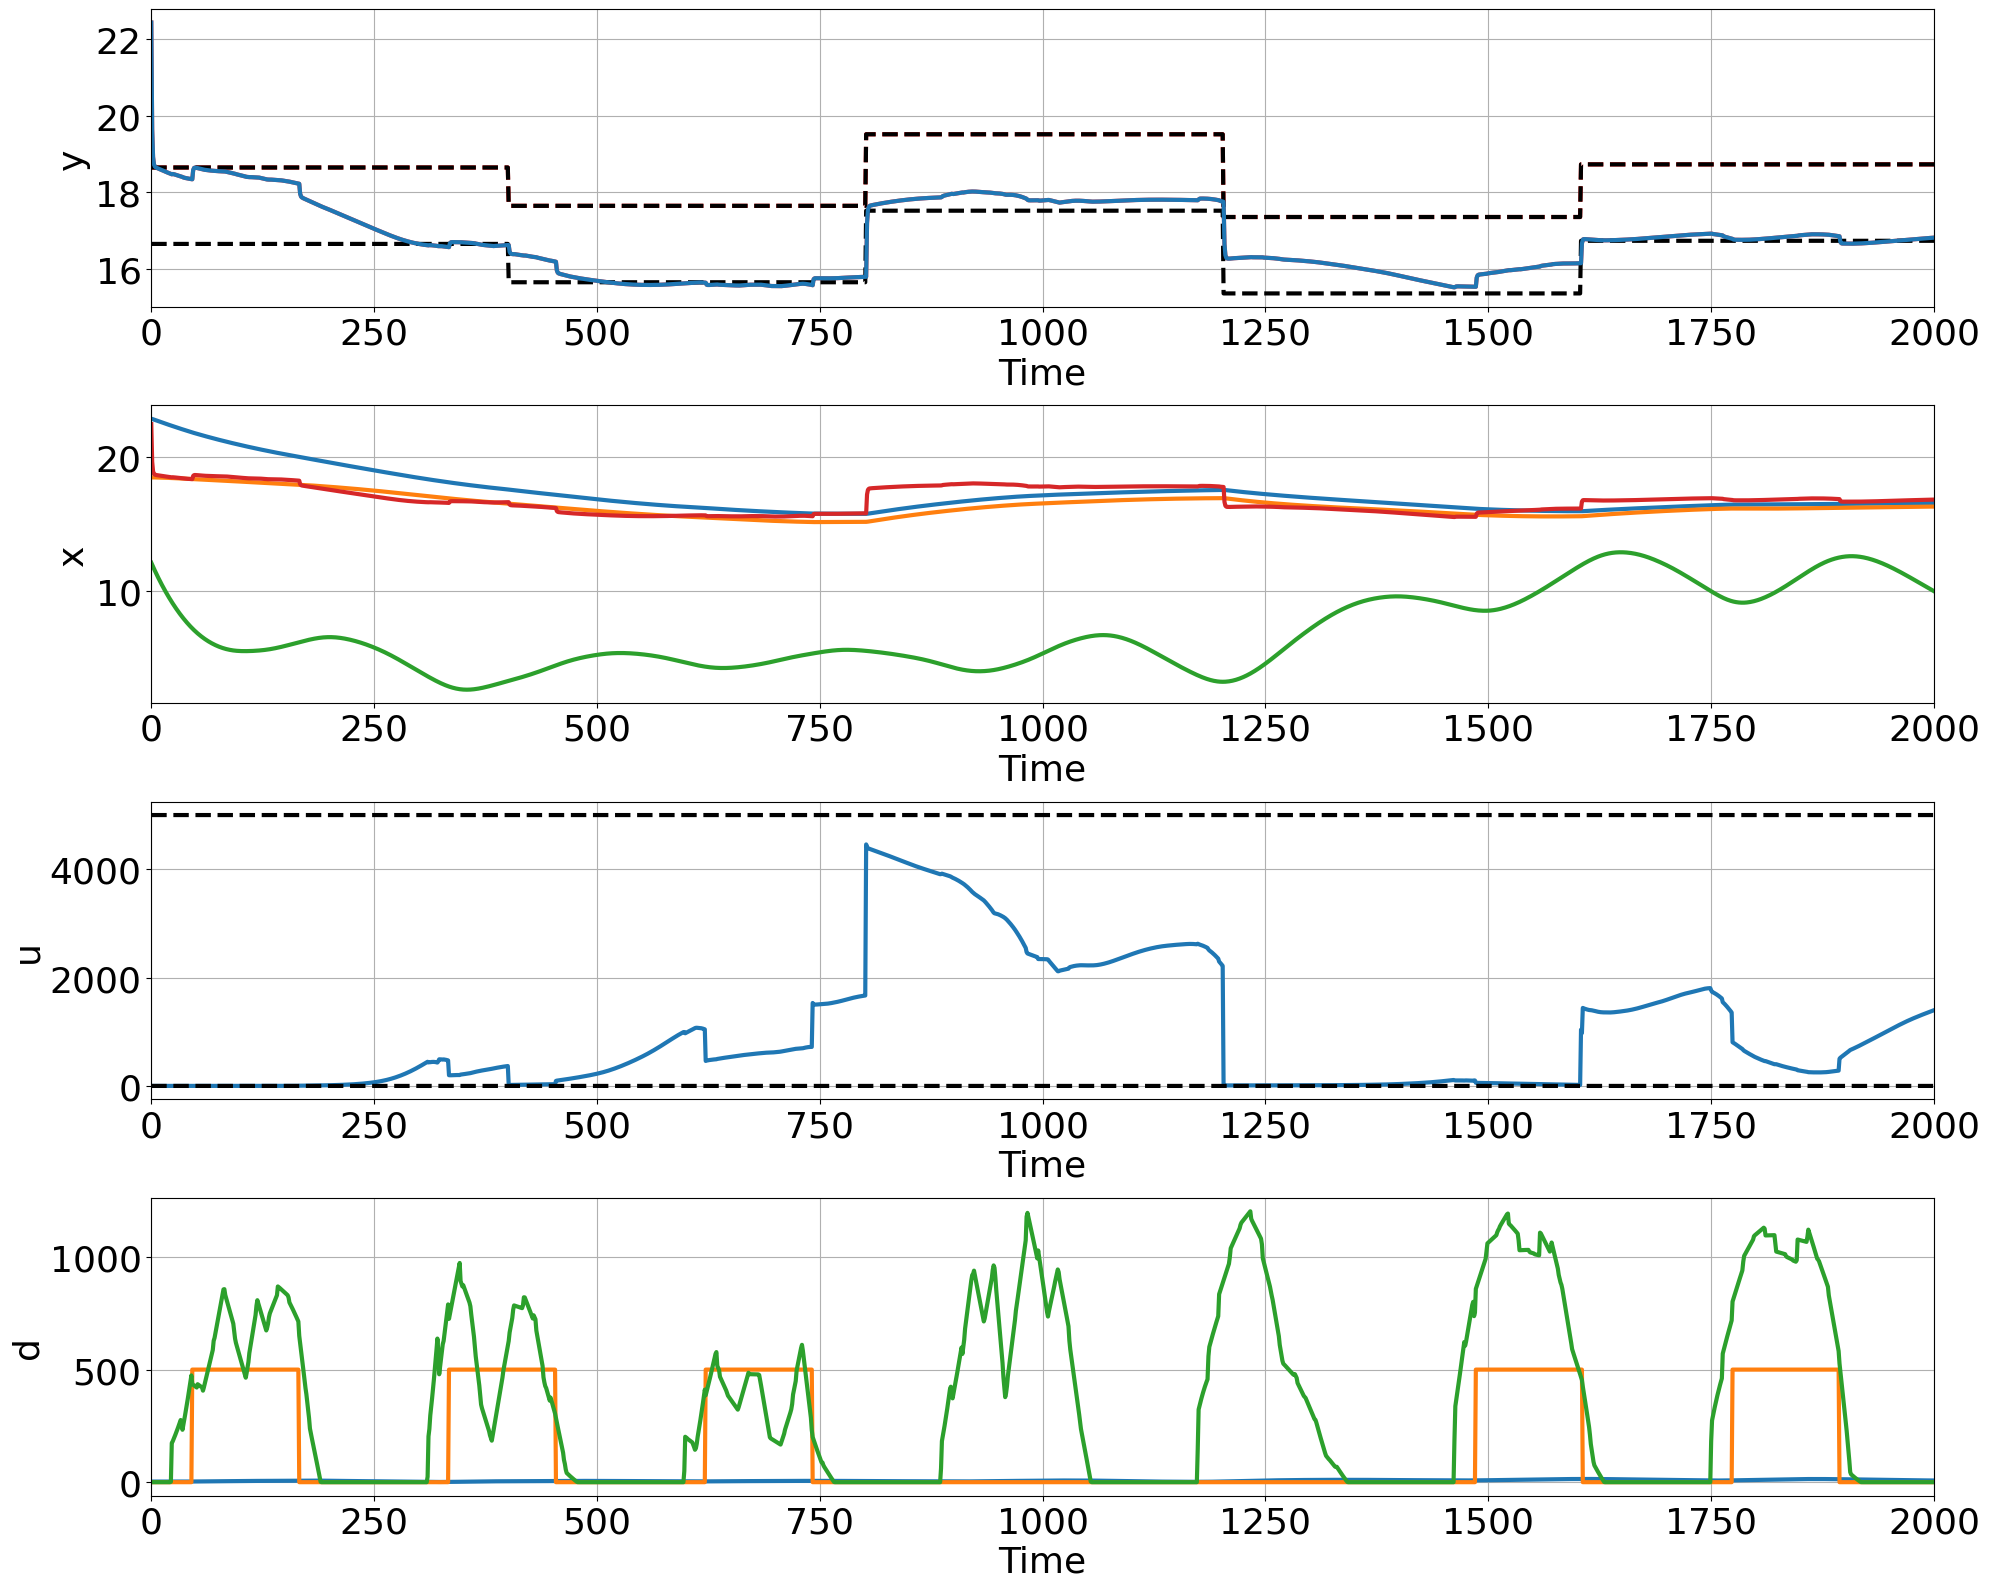

In [14]:
"""
Test Closed Loop System
"""
print('\nTest Closed Loop System \n')
nsteps_test = 2000
# generate reference
np_refs = psl.signals.step(nsteps_test+1, 1, min=15, max=20, randsteps=5)
ymin_val = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps_test+1, 1)
ymax_val = ymin_val+2.0
# generate disturbance signal
torch_dist = torch.tensor(system.get_D(nsteps_test+1)).unsqueeze(0)
# initial data for closed loop simulation
x0 = torch.tensor(system.get_x0()).reshape(1, 1, nx)
data = {'x': x0,
        'ymin': ymin_val,
        'ymax': ymax_val,
        'd': torch_dist}
cl_system.nsteps = nsteps_test
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps_test, nu])
Umax = umax * np.ones([nsteps_test, nu])
Ymin = trajectories['ymin'].detach().cpu().numpy().reshape(nsteps_test+1, nref) # Convert to numpy array
Ymax = trajectories['ymax'].detach().cpu().numpy().reshape(nsteps_test+1, nref) # Convert to numpy array
# plot closed loop trajectories
pltCL(Y=trajectories['y'].detach().cpu().numpy().reshape(nsteps_test, ny),  # Convert to numpy array
      R=Ymax,
      X=trajectories['x'].detach().cpu().numpy().reshape(nsteps_test+1, nx), # Convert to numpy array
      D=trajectories['d'].detach().cpu().numpy().reshape(nsteps_test+1, nd), # Convert to numpy array
      U=trajectories['u'].detach().cpu().numpy().reshape(nsteps_test, nu),  # Convert to numpy array
      Umin=Umin, Umax=Umax, Ymin=Ymin, Ymax=Ymax)

In [16]:
np_refs = psl.signals.step(nsteps_test+1, 1, min=x_min, max=x_max, randsteps=10)

In [17]:
np_refs

array([[18.35242946],
       [18.35242946],
       [18.35242946],
       ...,
       [18.63581218],
       [18.63581218],
       [18.63581218]])

In [18]:
trajectories["ymin"].shape

torch.Size([1, 2001, 1])

In [19]:
trajectories["y"][0,:,0] < trajectories["ymin"][0,:-1,0]


tensor([False, False, False,  ..., False, False, False])

In [20]:
trajectories["y"][0,390:420,0] 

tensor([18.0147, 18.0143, 18.0139, 18.0135, 18.0132, 18.0129, 18.0126, 18.0120,
        18.0083, 18.0061, 18.0043, 18.0017, 19.5308, 19.8335, 19.8954, 19.9084,
        19.9114, 19.9123, 19.9128, 19.9132, 19.9136, 19.9141, 19.9146, 19.9151,
        19.9156, 19.9161, 19.9166, 19.9171, 19.9176, 19.9180],
       grad_fn=<SelectBackward0>)

In [21]:
trajectories["u"][0,390:420,0] 

tensor([ 404.2722,  406.2975,  408.1760,  409.9055,  411.4841,  412.9092,
         415.2813,  425.3711,  429.8326,  434.2633,  440.8534, 3472.9333,
        3293.4746, 3255.4192, 3241.8110, 3233.0786, 3225.3892, 3217.9575,
        3211.1577, 3204.2939, 3196.6304, 3189.0203, 3181.4666, 3173.9709,
        3166.5334, 3159.1558, 3151.8364, 3144.5757, 3137.3730, 3130.2297],
       grad_fn=<SelectBackward0>)

In [22]:
trajectories["ymin"][0,390:420,0] 

tensor([17.9589, 17.9589, 17.9589, 17.9589, 17.9589, 17.9589, 17.9589, 17.9589,
        17.9589, 17.9589, 17.9589, 19.7980, 19.7980, 19.7980, 19.7980, 19.7980,
        19.7980, 19.7980, 19.7980, 19.7980, 19.7980, 19.7980, 19.7980, 19.7980,
        19.7980, 19.7980, 19.7980, 19.7980, 19.7980, 19.7980])